<a href="https://colab.research.google.com/github/meghana-bharadwaj/generative-adversarial-networks/blob/main/Basic_implementation_of_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

Loading MNIST Dataset

In [89]:
mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()

In [90]:
#Scale the inputs in the range of -1 and 1 for better training
x_train,x_test=x_train/255.0*2-1,x_test/255.0*2-1

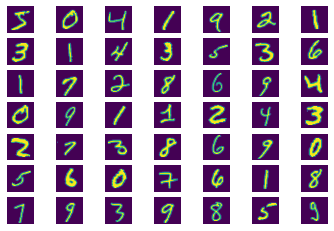

In [91]:
#plotting training images from the dataset

for i in range(49):
  plt.subplot(7,7,i+1)
  plt.axis("off")
  plt.imshow(x_train[i])
plt.show()

In [92]:
print("x_train.shape ",x_train.shape)
print("x_test.shape",x_test.shape)

x_train.shape  (60000, 28, 28)
x_test.shape (10000, 28, 28)


Flattening and Scaling the data - As the dimensions of the dataset is 3 we will flatten it to 2 dimensions and 28*28 means 684 and get converted to 60000 by 684

In [93]:
N, H , W = x_train.shape #number, height, width
D = H*W #dimension(28,28)
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1,D)

In [94]:
print("x_train.shape ",x_train.shape)
print("x_test.shape",x_test.shape)

x_train.shape  (60000, 784)
x_test.shape (10000, 784)


# Defining Generator Model
defining a function to develop a deep convolutional neural network, latent dimension is a variable that defines the number of inputs to model. We define the input layer, three hidden layers followed by Batch normalization, and activation function as Leaky RELU and an output layer with activation function as tanh because a range of Image pixel is between -1 and +1.

In [95]:
latent_dim = 100
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)  #because Image pixel is between -1 to 1.
  model = Model(i, x)  #i is input x is output layer
  return model

# Why do we use Leaky RELU?

Leaky relu helps the Gradient flow easily through the neural network architecture.

The ReLU activation function only takes the maximum value between input and zero. If we use ReLU then it is a chance that the network can get stuck in a state known as Dying State. If this happens then it produces nothing other than zero for all outputs.
Our aim is to get the value of gradient from Discriminator to make the generator work, and If the network gets stuck then learning will not happen.
Leaky ReLU uses a parameter known as alpha to control negative values and never zero passes. If the input is positive then it will exhibit a positive value, and if receive negative then multiply it with alpha and allow some negative value to pass through the network.

#Why Batch Normalization?

It has the effect of stabilizing the training process by standardizing activations from the prior layer to have zero mean and unit variance. Batch Normalization has become a staple while training deep convolutional Networks and GANs are no different from it.

Applying batch norm directly to all layers resulted in sample oscillation and model instability

# Defining Discriminator Model

Here we develop a simple Feed Forward Neural network for Discriminator where we will pass an image size. The activation function used is Leaky ReLU and you know the reason for it and sigmoid is used in the output layer for binary classification problems to classify Images as real or Fake.

In [96]:
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

In [97]:
# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile ( loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
# Build and compile the combined model
generator = build_generator(latent_dim)

In [98]:
generator.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_38 (Dense)            (None, 256)               25856     
                                                                 
 batch_normalization_15 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_39 (Dense)            (None, 512)               131584    
                                                                 
 batch_normalization_16 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_40 (Dense)            (None, 1024)              525

In [99]:
discriminator.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_35 (Dense)            (None, 512)               401920    
                                                                 
 dense_36 (Dense)            (None, 256)               131328    
                                                                 
 dense_37 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


#Represent Noise Sample

Now we will create input to represent noise samples from latent space. And we pass this noise to a generator to generate an Image. After this, we pass the generator Image to Discriminator and predict that it is Fake or real. In the initial phase, we do not want the discriminator to be trained and the image is Fake.

In [100]:
## Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))
## Pass noise through a generator to get an Image
img = generator(z)
discriminator.trainable = False
fake_pred = discriminator(img)

In [101]:
z.shape

TensorShape([None, 100])

In [102]:
combined_model_gen = Model(z, fake_pred) 
combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [103]:
batch_size = 32
epochs = 30000
sample_period = 200
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)
#store generator and discriminator loss in each step or each epoch
d_losses = []
g_losses = []
#create a file in which generator will create and save images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

#Function to create Sample images
Create a function that generates a grid of random samples from a generator and saves them to a file. In simple words, it will create random images on some epochs.

We define the row size as 5 and column as also 5 so in a single iteration or on a single page it will generate 25 images.

In [104]:
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)
  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5
  fig, axs = plt.subplots(rows, cols)  #fig to plot img and axis to store
  idx = 0
  for i in range(rows):  #5*5 loop means on page 25 imgs will be there
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

#Train Discriminator and then Generator to generate Images
Now let’s start the training Discriminator. We have to pass real images means MNIST dataset as well some Fake Images to Discriminator to train it well that it is capable to classify images. After this, we create a random noise grid the same as of real image and pass it to a generator to generate a new image. After this, we calculate the loss of both models and in a generated image, we pass the label as one to fool the Discriminator to believe and check that it is capable to identify it as Fake or not.

In [ ]:
#FIRST we will train Discriminator(with real imgs and fake imgs)
# Main training loop
for epoch in range(epochs):
  
  ### Train discriminator ###

  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]  #MNIST dataset
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)  #generator to generate fake imgs
  fake_imgs = generator.predict(noise)
  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)  #belong to positive class(real imgs)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)  #fake imgs
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  #######################
  ### Train generator ###
  #######################
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)  
  #Now we are trying to fool the discriminator that generate imgs are real that's why we are providing label as 1
  # do it again!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)
  # Save the losses
  d_losses.append(d_loss)  #save the loss at each epoch
  g_losses.append(g_loss)
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f},d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  if epoch % sample_period == 0:
    sample_images(epoch)

epoch: 1/30000, d_loss: 0.74,d_acc: 0.47, g_loss: 0.77
epoch: 101/30000, d_loss: 0.04,d_acc: 0.98, g_loss: 4.16
epoch: 201/30000, d_loss: 0.62,d_acc: 0.66, g_loss: 1.23
epoch: 301/30000, d_loss: 0.72,d_acc: 0.47, g_loss: 0.59
epoch: 401/30000, d_loss: 0.69,d_acc: 0.47, g_loss: 0.62
epoch: 501/30000, d_loss: 0.69,d_acc: 0.45, g_loss: 0.64
epoch: 601/30000, d_loss: 0.69,d_acc: 0.47, g_loss: 0.65
epoch: 701/30000, d_loss: 0.67,d_acc: 0.53, g_loss: 0.68
epoch: 801/30000, d_loss: 0.69,d_acc: 0.50, g_loss: 0.68
epoch: 901/30000, d_loss: 0.68,d_acc: 0.53, g_loss: 0.70
epoch: 1001/30000, d_loss: 0.68,d_acc: 0.53, g_loss: 0.72
epoch: 1101/30000, d_loss: 0.66,d_acc: 0.62, g_loss: 0.73
epoch: 1201/30000, d_loss: 0.62,d_acc: 0.72, g_loss: 0.77
epoch: 1301/30000, d_loss: 0.65,d_acc: 0.72, g_loss: 0.75
epoch: 1401/30000, d_loss: 0.65,d_acc: 0.61, g_loss: 0.79
epoch: 1501/30000, d_loss: 0.64,d_acc: 0.67, g_loss: 0.75
epoch: 1601/30000, d_loss: 0.64,d_acc: 0.67, g_loss: 0.82
epoch: 1701/30000, d_loss:

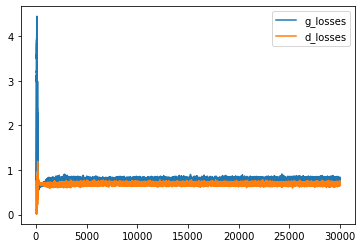

In [109]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

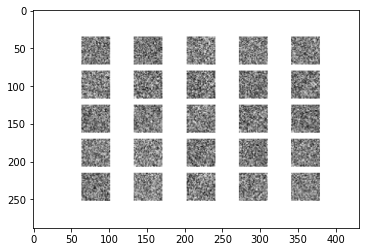

In [110]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

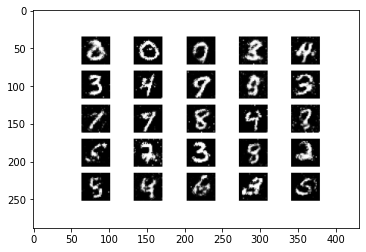

In [111]:
from skimage.io import imread
a = imread('gan_images/10000.png')
plt.imshow(a)